In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from lightgbm import LGBMRanker, LGBMRegressor
from multiprocessing import cpu_count

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [4]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2, rank_col='Rank') -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """

    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df[rank_col].min() == 0
        assert df[rank_col].max() == len(df[rank_col]) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by=rank_col)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by=rank_col, ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf


In [5]:
def set_rank(df):
    """
    Args:
        df (pd.DataFrame): including predict column
    Returns:
        df (pd.DataFrame): df with Rank
    """
    # sort records to set Rank
    df = df.sort_values("predict", ascending=False)
    # set Rank starting from 0
    df.loc[:, "Rank"] = np.arange(len(df["predict"]))
    return df

In [6]:
train = pd.read_parquet('../Output/financials_train_agg_df.parquet')
val = pd.read_parquet('../Output/financials_val_agg_df.parquet')
df = pd.concat([train, val]).reset_index(drop=True)
rank_num = 100
df["qcut"] = pd.qcut(df['Target'], rank_num, duplicates='drop').cat.codes

In [7]:
df["Section/Products"] = df["Section/Products"].astype('category').cat.codes
df["NewMarketSegment"] = df["NewMarketSegment"].astype('category').cat.codes
df["33SectorCode"] = df["33SectorCode"].astype('category').cat.codes
df["17SectorCode"] = df["17SectorCode"].astype('category').cat.codes
df["NewIndexSeriesSizeCode"] = df["NewIndexSeriesSizeCode"].astype('category').cat.codes
df["week"] = df["week"].astype('category').cat.codes
df["TypeOfDocument"] = df["TypeOfDocument"].astype('category').cat.codes

In [8]:
agg_df = df.groupby('SecuritiesCode')[['AdjustedOpen', 'AdjustedHigh', 'AdjustedLow', 'AdjustedClose']].agg(['median', 'max', 'min'])


In [9]:
agg_df.columns = [f'{c[0]}_{c[1]}'  for c in agg_df.columns]

In [10]:
agg_df

,AdjustedOpen_median,AdjustedOpen_max,AdjustedOpen_min,AdjustedHigh_median,AdjustedHigh_max,AdjustedHigh_min,AdjustedLow_median,AdjustedLow_max,AdjustedLow_min,AdjustedClose_median,AdjustedClose_max,AdjustedClose_min
SecuritiesCode,,,,,,,,,,,,
1301,3005.0,4430.0,2255.0,3025.0,4460.0,2326.0,2986.5,4340.0,2202.0,3005.0,4430.0,2289.0
1332,583.0,852.0,404.0,588.0,863.0,410.0,577.0,838.0,398.0,582.5,849.0,401.0
1333,2949.0,4520.0,1880.0,2980.5,4580.0,1952.0,2918.5,4475.0,1846.0,2938.5,4510.0,1889.0
1375,1701.0,2134.0,1102.0,1715.0,2173.0,1132.0,1685.0,2113.0,1101.0,1698.0,2145.0,1111.0
1376,1484.0,1784.0,875.0,1493.0,1820.0,917.0,1470.0,1757.0,869.0,1481.5,1769.0,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9990,917.0,1463.0,480.0,921.5,1496.0,487.0,908.5,1442.0,473.0,912.5,1487.0,473.0
9991,1004.0,1430.0,671.0,1010.5,1443.0,722.0,991.5,1421.0,665.0,1002.5,1424.0,693.0
9993,1733.0,1918.0,1148.0,1740.0,2090.0,1224.0,1723.0,1888.0,1121.0,1731.0,1925.0,1224.0


In [11]:
join_df = pd.merge(df, agg_df, on='SecuritiesCode', how='left')

In [12]:
join_df

,RowId,Date,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Section/Products,NewMarketSegment,33SectorCode,17SectorCode,NewIndexSeriesSizeCode,Universe0,day,weekday,week,month,high_rank,CumulativeAdjustmentFactor,AdjustedOpen,AdjustedHigh,AdjustedLow,AdjustedClose,ror_1,ror_2,ror_3,ror_4,ror_5,ror_6,ror_7,ror_8,ror_9,ror_10,ror_20,ror_40,ror_60,ror_100,TradedAmount,TradedAmount_1,TradedAmount_5,TradedAmount_10,TradedAmount_20,TradedAmount_40,TradedAmount_60,TradedAmount_100,d_Amount,PreviousClose,range,range_1,range_5,range_10,range_20,range_40,range_60,range_100,d_atr,gap_range,gap_range_1,gap_range_5,gap_range_10,gap_range_20,gap_range_40,gap_range_60,gap_range_100,day_range,day_range_1,day_range_5,day_range_10,day_range_20,day_range_40,day_range_60,day_range_100,hig_range,hig_range_1,hig_range_5,hig_range_10,hig_range_20,hig_range_40,hig_range_60,hig_range_100,mi,mi_1,mi_5,mi_10,mi_20,mi_40,mi_60,mi_100,vola_5,vola_10,vola_20,vola_40,vola_60,vola_100,hl_5,hl_10,hl_20,hl_40,hl_60,hl_100,ror_1_shift1,ror_1_shift2,ror_1_shift3,ror_1_shift4,ror_1_shift5,ror_1_shift6,ror_1_shift7,ror_1_shift8,ror_1_shift9,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,ror_1_AdjustedOpen_lag1_max,ror_1_AdjustedOpen_lag1_min,d_Amount_AdjustedClose_lag1_max,d_Amount_AdjustedClose_lag1_min,TradedAmount_1_AdjustedClose_lag1_max,TradedAmount_1_AdjustedClose_lag1_min,d_atr_Target_lag1_max,d_atr_Target_lag1_min,day_range_1_Target_lag1_max,day_range_1_Target_lag1_min,vola_5_high_rank_lag1_max,vola_5_high_rank_lag1_min,gap_range_1_high_rank_lag1_max,gap_range_1_high_rank_lag1_min,ror_1_mean_5,ror_1_var_5,ror_1_max_5,ror_1_min_5,ror_1_skew_5,ror_1_kurt_5,ror_1_ewm_mean_5,ror_1_ewm_std_5,DisclosureNumber,DateCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,CurrentFiscalYearStartDate,CurrentFiscalYearEndDate,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NetSales,OperatingProfit,OrdinaryProfit,Profit,EarningsPerShare,TotalAssets,Equity,EquityToAssetRatio,BookValuePerShare,ResultDividendPerShare1stQuarter,ResultDividendPerShare2ndQuarter,ResultDividendPerShare3rdQuarter,ResultDividendPerShareFiscalYearEnd,ResultDividendPerShareAnnual,ForecastDividendPerShare1stQuarter,ForecastDividendPerShare2ndQuarter,ForecastDividendPerShare3rdQuarter,ForecastDividendPerShareFiscalYearEnd,ForecastDividendPerShareAnnual,ForecastNetSales,ForecastOperatingProfit,ForecastOrdinaryProfit,ForecastProfit,ForecastEarningsPerShare,NumberOfIssuedAndOutstandingShar

In [13]:
def price_diff(df, columns):
    for col in columns:
        df[f'{col}DiffMedian'] = (df[col] - df[f'{col}_median'])
        df[f'{col}MaxDiffMedian'] = (df[f'{col}_max'] - df[f'{col}_median'])
        df[f'{col}MinDiffMedian'] = - (df[f'{col}_min'] - df[f'{col}_median'])
    return df

In [14]:
join_df = price_diff(join_df, columns=['AdjustedOpen', 'AdjustedHigh', 'AdjustedLow', 'AdjustedClose'])

In [15]:
# join_df['AdjustedCloseDiffMedian'] = (join_df['AdjustedClose'] - join_df['median'])
# join_df['MaxDiffMedian'] = (join_df['max'] - join_df['median'])
# join_df['MinDiffMedian'] = - (join_df['min'] - join_df['median'])

In [16]:
join_df[['AdjustedCloseDiffMedian', 'AdjustedCloseMaxDiffMedian', 'AdjustedCloseMinDiffMedian']]

,AdjustedCloseDiffMedian,AdjustedCloseMaxDiffMedian,AdjustedCloseMinDiffMedian
0,-263.0,1425.0,716.0
1,-11.5,266.5,181.5
2,271.5,1571.5,1049.5
3,68.5,287.5,581.5
4,-255.0,860.0,1117.0
...,...,...,...
2444526,-396.5,574.5,439.5
2444527,-180.5,421.5,309.5
2444528,-131.0,194.0,507.0
2444529,308.0,1868.0,709.0


In [17]:
def scaler(x, max, min):
    if x > 0:
        return x / max
    else:
        return x / min

In [18]:
join_df['ScaledAdjustedOpen'] = np.vectorize(scaler)(join_df['AdjustedOpenDiffMedian'], join_df['AdjustedOpenMaxDiffMedian'], join_df['AdjustedOpenMinDiffMedian'])
join_df['ScaledAdjustedHigh'] = np.vectorize(scaler)(join_df['AdjustedHighDiffMedian'], join_df['AdjustedHighMaxDiffMedian'], join_df['AdjustedHighMinDiffMedian'])
join_df['ScaledAdjustedLow'] = np.vectorize(scaler)(join_df['AdjustedLowDiffMedian'], join_df['AdjustedLowMaxDiffMedian'], join_df['AdjustedLowMinDiffMedian'])
join_df['ScaledAdjustedClose'] = np.vectorize(scaler)(join_df['AdjustedCloseDiffMedian'], join_df['AdjustedCloseMaxDiffMedian'], join_df['AdjustedCloseMinDiffMedian'])

In [19]:
join_df['close_arcsin_deg'] = np.degrees(np.arcsin(join_df['ScaledAdjustedClose']))
join_df['close_arccos_deg'] = np.degrees(np.arccos(join_df['ScaledAdjustedClose']))
join_df['close_arctan_deg'] = np.degrees(np.arctan(join_df['ScaledAdjustedClose']))

In [20]:
join_df[join_df['SecuritiesCode'] == 1301][['ScaledAdjustedClose', 'AdjustedClose', 'close_arcsin_deg', 'close_arccos_deg', 'close_arctan_deg']]

,ScaledAdjustedClose,AdjustedClose,close_arcsin_deg,close_arccos_deg,close_arctan_deg
0,-0.367318,2742.0,-21.550333,111.550333,-20.169214
1865,-0.372905,2738.0,-21.894890,111.894890,-20.450738
3730,-0.370112,2740.0,-21.722508,111.722508,-20.310104
5595,-0.358939,2748.0,-21.035023,111.035023,-19.745019
7460,-0.363128,2745.0,-21.292452,111.292452,-19.957402
...,...,...,...,...,...
2434531,0.140351,3205.0,8.068151,81.931849,7.989327
2436531,0.136842,3200.0,7.865153,82.134847,7.792078
2438531,0.133333,3195.0,7.662256,82.337744,7.594643
2440531,0.101754,3150.0,5.840205,84.159795,5.810099


In [21]:
SecuritiesCode_list = join_df['SecuritiesCode'].unique()

In [22]:
first_df = join_df[join_df['SecuritiesCode'] == SecuritiesCode_list[0]].reset_index()

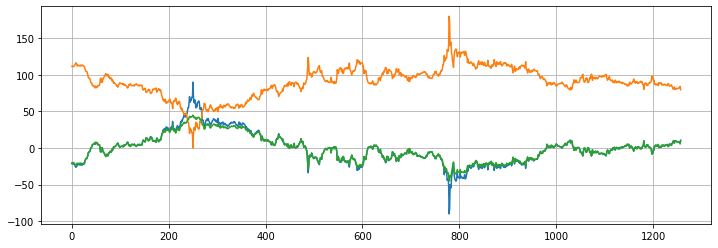

In [23]:
plt.figure(figsize=(12,4))
# plt.scatter(first_df.index, first_df['AdjustedClose'])
plt.plot(first_df.index, first_df['close_arcsin_deg'])
plt.plot(first_df.index, first_df['close_arccos_deg'])
plt.plot(first_df.index, first_df['close_arctan_deg'])
plt.grid()
plt.show()

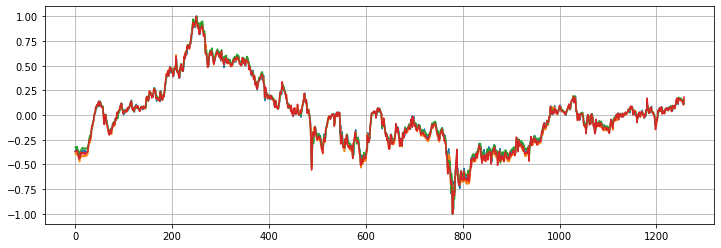

In [24]:
plt.figure(figsize=(12,4))
# plt.scatter(first_df.index, first_df['AdjustedClose'])
plt.plot(first_df.index, first_df['ScaledAdjustedOpen'])
plt.plot(first_df.index, first_df['ScaledAdjustedHigh'])
plt.plot(first_df.index, first_df['ScaledAdjustedLow'])
plt.plot(first_df.index, first_df['ScaledAdjustedClose'])

plt.grid()
plt.show()

In [25]:
first_df[first_df['trend_psar_up_indicator'] == 1.0].index

Int64Index([  11,   76,   90,  112,  140,  175,  185,  206,  224,  250,  277,
             293,  327,  345,  378,  413,  422,  451,  469,  491,  516,  538,
             560,  575,  601,  623,  651,  680,  721,  732,  755,  773,  785,
             817,  851,  864,  877,  888,  937,  939,  963,  986, 1000, 1018,
            1057, 1080, 1105, 1128, 1165, 1179, 1203, 1224, 1234, 1257],
           dtype='int64')

In [26]:
first_df[first_df['trend_psar_down_indicator'] == 1.0].index

Int64Index([   2,   50,   88,   99,  119,  166,  180,  201,  212,  247,  254,
             286,  306,  339,  351,  388,  416,  434,  461,  478,  508,  534,
             547,  567,  586,  621,  631,  669,  700,  725,  746,  762,  775,
             794,  838,  859,  872,  878,  914,  938,  954,  984,  994, 1011,
            1034, 1069, 1094, 1123, 1151, 1174, 1184, 1212, 1233, 1252],
           dtype='int64')

In [27]:
join_df['trend_psa_indicator'] = join_df['trend_psar_up_indicator'] - join_df['trend_psar_down_indicator']

In [28]:
join_df['trend_psa_indicator'].value_counts()

 0.0    2233870
-1.0     105950
 1.0     104711
Name: trend_psa_indicator, dtype: int64

In [29]:
first_df['trend_aroon_ind']

0      -20.0
1      -20.0
2      -20.0
3      -20.0
4      -20.0
        ... 
1253    48.0
1254    48.0
1255    48.0
1256    44.0
1257    96.0
Name: trend_aroon_ind, Length: 1258, dtype: float64

In [30]:
join_df['trend_aroon_ind'] = join_df['trend_aroon_ind'].astype(int)
join_df['trend_aroon_ind_diff1'] = join_df.groupby('SecuritiesCode')['trend_aroon_ind'].diff(1)

In [31]:
join_df['trend_aroon_ind_diff1'].value_counts()

 0.0      1411850
 4.0       220356
-4.0       219984
 8.0        58026
-8.0        57935
 1.0        49306
-1.0        49147
 12.0       29842
-12.0       29336
 16.0       20115
-16.0       19943
-20.0       14580
 20.0       14189
-24.0       11383
 24.0       11127
 100.0      10898
-100.0      10288
 28.0        8390
-28.0        8156
 32.0        7822
-32.0        7479
 36.0        6664
-36.0        6407
-40.0        6386
 40.0        5983
 96.0        5568
-44.0        5558
-96.0        5477
 44.0        5228
-52.0        4929
-48.0        4917
 92.0        4636
 48.0        4498
-92.0        4443
 52.0        4000
 60.0        3871
 88.0        3799
-64.0        3764
 5.0         3723
 64.0        3710
-60.0        3660
 84.0        3530
-68.0        3517
 68.0        3514
-88.0        3487
-5.0         3470
-84.0        3392
-80.0        3378
 72.0        3324
 3.0         3314
 56.0        3281
-76.0        3275
 80.0        3257
-72.0        3159
-56.0        3070
-3.0      

In [32]:
second_df = join_df[join_df['SecuritiesCode'] == SecuritiesCode_list[1]].reset_index()

In [33]:
[c for c in join_df.columns]

['RowId',
 'Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'AdjustmentFactor',
 'ExpectedDividend',
 'SupervisionFlag',
 'Target',
 'Section/Products',
 'NewMarketSegment',
 '33SectorCode',
 '17SectorCode',
 'NewIndexSeriesSizeCode',
 'Universe0',
 'day',
 'weekday',
 'week',
 'month',
 'high_rank',
 'CumulativeAdjustmentFactor',
 'AdjustedOpen',
 'AdjustedHigh',
 'AdjustedLow',
 'AdjustedClose',
 'ror_1',
 'ror_2',
 'ror_3',
 'ror_4',
 'ror_5',
 'ror_6',
 'ror_7',
 'ror_8',
 'ror_9',
 'ror_10',
 'ror_20',
 'ror_40',
 'ror_60',
 'ror_100',
 'TradedAmount',
 'TradedAmount_1',
 'TradedAmount_5',
 'TradedAmount_10',
 'TradedAmount_20',
 'TradedAmount_40',
 'TradedAmount_60',
 'TradedAmount_100',
 'd_Amount',
 'PreviousClose',
 'range',
 'range_1',
 'range_5',
 'range_10',
 'range_20',
 'range_40',
 'range_60',
 'range_100',
 'd_atr',
 'gap_range',
 'gap_range_1',
 'gap_range_5',
 'gap_range_10',
 'gap_range_20',
 'gap_range_40',
 'gap_range_60',
 'gap_range_100',
 'day_range',
 'd

In [34]:
def simple_model(x, y):
    if x > 0:
        return y
    else:
        return -y

In [35]:
def rolling_mean(df, target_col, period=5):
    rolling_df = pd.DataFrame()
    rolling_df[['level_1', f'{target_col}_sma_{period}']] = (
        df.groupby('SecuritiesCode')[target_col]
            .rolling(period).mean().reset_index()[['level_1', target_col]]
    )
    rolling_df = rolling_df.set_index('level_1').sort_values('level_1').reset_index(drop=True)

    return pd.concat([df, rolling_df], axis=1)


In [36]:
def rolling_std(df, target_col, period=5):
    rolling_df = pd.DataFrame()
    rolling_df[['level_1', f'{target_col}_std_{period}']] = (
        df.groupby('SecuritiesCode')[target_col]
            .rolling(period).std().reset_index()[['level_1', target_col]]
    )
    rolling_df = rolling_df.set_index('level_1').sort_values('level_1').reset_index(drop=True)

    return pd.concat([df, rolling_df], axis=1)

In [37]:
join_df = rolling_mean(join_df, 'ScaledAdjustedClose', 5)
join_df = rolling_mean(join_df, 'ScaledAdjustedClose', 10)
join_df = rolling_mean(join_df, 'ScaledAdjustedClose', 25)
join_df = rolling_mean(join_df, 'ScaledAdjustedClose', 30)
join_df = rolling_mean(join_df, 'ScaledAdjustedClose', 40)
join_df = rolling_mean(join_df, 'ScaledAdjustedClose', 60)
join_df = rolling_mean(join_df, 'ScaledAdjustedClose', 100)
join_df = rolling_std(join_df, 'ScaledAdjustedClose', 5)
join_df = rolling_std(join_df, 'ScaledAdjustedClose', 10)
join_df = rolling_std(join_df, 'ScaledAdjustedClose', 25)
join_df = rolling_std(join_df, 'ScaledAdjustedClose', 30)
join_df = rolling_std(join_df, 'ScaledAdjustedClose', 40)
join_df = rolling_std(join_df, 'ScaledAdjustedClose', 60)
join_df = rolling_std(join_df, 'ScaledAdjustedClose', 100)

In [38]:
join_df["ac_sma_5_pct_change"] = join_df.groupby('SecuritiesCode')['ScaledAdjustedClose_sma_5'].pct_change(1)
join_df["ac_sma_10_pct_change"] = join_df.groupby('SecuritiesCode')['ScaledAdjustedClose_sma_10'].pct_change(1)
join_df["ac_sma_25_pct_change"] = join_df.groupby('SecuritiesCode')['ScaledAdjustedClose_sma_25'].pct_change(1)
join_df["ac_sma_30_pct_change"] = join_df.groupby('SecuritiesCode')['ScaledAdjustedClose_sma_30'].pct_change(1)
join_df["ac_sma_40_pct_change"] = join_df.groupby('SecuritiesCode')['ScaledAdjustedClose_sma_40'].pct_change(1)
join_df["ac_sma_60_pct_change"] = join_df.groupby('SecuritiesCode')['ScaledAdjustedClose_sma_60'].pct_change(1)
join_df["ac_sma_100_pct_change"] = join_df.groupby('SecuritiesCode')['ScaledAdjustedClose_sma_100'].pct_change(1)

In [39]:
join_df["volume_pct_change"] = join_df.groupby('SecuritiesCode')['Volume'].pct_change(1)

In [40]:
join_df['ror1_ror2'] = join_df['ror_1'] * join_df['ror_2']
join_df['ror1_ror3'] = join_df['ror_1'] * join_df['ror_3']
join_df['ror1_ror4'] = join_df['ror_1'] * join_df['ror_4']
join_df['ror1_ror5'] = join_df['ror_1'] * join_df['ror_5']

In [41]:
join_df['volume_pct_change_ror_1'] = join_df["volume_pct_change"] * join_df['ror_1']

In [42]:
join_df['sma_5_25'] = np.vectorize(simple_model)(join_df['ac_sma_5_pct_change'], join_df['ScaledAdjustedClose_std_25'])
join_df['sma_25_30'] = np.vectorize(simple_model)(join_df['ac_sma_25_pct_change'], join_df['ScaledAdjustedClose_std_30'])


In [43]:
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
from sklearn.model_selection._split import _BaseKFold

import lightgbm as lgb

In [44]:
# self defined GroupTimeSeriesSplit
class GroupTimeSeriesSplit(_BaseKFold):

    def __init__(self, n_splits=5, *, max_train_size=None):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        n_splits = self.n_splits
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_folds = n_splits + 1
        indices = np.arange(n_samples)
        group_counts = np.unique(groups, return_counts=True)[1]
        groups = np.split(indices, np.cumsum(group_counts)[:-1])
        n_groups = _num_samples(groups)
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of groups: {1}.").format(n_folds, n_groups))
        test_size = (n_groups // n_folds)
        test_starts = range(test_size + n_groups % n_folds,
                            n_groups, test_size)
        for test_start in test_starts:
            if self.max_train_size:
                train_start = np.searchsorted(
                    np.cumsum(
                        group_counts[:test_start][::-1])[::-1] < self.max_train_size + 1, 
                        True)
                yield (np.concatenate(groups[train_start:test_start]),
                       np.concatenate(groups[test_start:test_start + test_size]))
            else:
                yield (np.concatenate(groups[:test_start]),
                       np.concatenate(groups[test_start:test_start + test_size]))

In [45]:
join_df = join_df.replace([np.inf, -np.inf], np.nan).fillna(0)

time_config = {'val_split_date': '2021-11-01',
               'test_split_date': '2022-01-01'}

train = join_df[(join_df.Date < time_config['val_split_date'])]
val = join_df[(join_df.Date >= time_config['val_split_date']) & (join_df.Date < time_config['test_split_date'])]
test = join_df[(join_df.Date >= time_config['test_split_date'])]

In [117]:
# train.to_parquet('../Output/train_scaling.parquet')
# val.to_parquet('../Output/valid_scaling.parquet')
# test.to_parquet('../Output/test_scaling.parquet')

In [46]:
val

,RowId,Date,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Section/Products,NewMarketSegment,33SectorCode,17SectorCode,NewIndexSeriesSizeCode,Universe0,day,weekday,week,month,high_rank,CumulativeAdjustmentFactor,AdjustedOpen,AdjustedHigh,AdjustedLow,AdjustedClose,ror_1,ror_2,ror_3,ror_4,ror_5,ror_6,ror_7,ror_8,ror_9,ror_10,ror_20,ror_40,ror_60,ror_100,TradedAmount,TradedAmount_1,TradedAmount_5,TradedAmount_10,TradedAmount_20,TradedAmount_40,TradedAmount_60,TradedAmount_100,d_Amount,PreviousClose,range,range_1,range_5,range_10,range_20,range_40,range_60,range_100,d_atr,gap_range,gap_range_1,gap_range_5,gap_range_10,gap_range_20,gap_range_40,gap_range_60,gap_range_100,day_range,day_range_1,day_range_5,day_range_10,day_range_20,day_range_40,day_range_60,day_range_100,hig_range,hig_range_1,hig_range_5,hig_range_10,hig_range_20,hig_range_40,hig_range_60,hig_range_100,mi,mi_1,mi_5,mi_10,mi_20,mi_40,mi_60,mi_100,vola_5,vola_10,vola_20,vola_40,vola_60,vola_100,hl_5,hl_10,hl_20,hl_40,hl_60,hl_100,ror_1_shift1,ror_1_shift2,ror_1_shift3,ror_1_shift4,ror_1_shift5,ror_1_shift6,ror_1_shift7,ror_1_shift8,ror_1_shift9,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,ror_1_AdjustedOpen_lag1_max,ror_1_AdjustedOpen_lag1_min,d_Amount_AdjustedClose_lag1_max,d_Amount_AdjustedClose_lag1_min,TradedAmount_1_AdjustedClose_lag1_max,TradedAmount_1_AdjustedClose_lag1_min,d_atr_Target_lag1_max,d_atr_Target_lag1_min,day_range_1_Target_lag1_max,day_range_1_Target_lag1_min,vola_5_high_rank_lag1_max,vola_5_high_rank_lag1_min,gap_range_1_high_rank_lag1_max,gap_range_1_high_rank_lag1_min,ror_1_mean_5,ror_1_var_5,ror_1_max_5,ror_1_min_5,ror_1_skew_5,ror_1_kurt_5,ror_1_ewm_mean_5,ror_1_ewm_std_5,DisclosureNumber,DateCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,CurrentFiscalYearStartDate,CurrentFiscalYearEndDate,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NetSales,OperatingProfit,OrdinaryProfit,Profit,EarningsPerShare,TotalAssets,Equity,EquityToAssetRatio,BookValuePerShare,ResultDividendPerShare1stQuarter,ResultDividendPerShare2ndQuarter,ResultDividendPerShare3rdQuarter,ResultDividendPerShareFiscalYearEnd,ResultDividendPerShareAnnual,ForecastDividendPerShare1stQuarter,ForecastDividendPerShare2ndQuarter,ForecastDividendPerShare3rdQuarter,ForecastDividendPerShareFiscalYearEnd,ForecastDividendPerShareAnnual,ForecastNetSales,ForecastOperatingProfit,ForecastOrdinaryProfit,ForecastProfit,ForecastEarningsPerShare,NumberOfIssuedAndOutstandingShar

In [47]:
test

,RowId,Date,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Section/Products,NewMarketSegment,33SectorCode,17SectorCode,NewIndexSeriesSizeCode,Universe0,day,weekday,week,month,high_rank,CumulativeAdjustmentFactor,AdjustedOpen,AdjustedHigh,AdjustedLow,AdjustedClose,ror_1,ror_2,ror_3,ror_4,ror_5,ror_6,ror_7,ror_8,ror_9,ror_10,ror_20,ror_40,ror_60,ror_100,TradedAmount,TradedAmount_1,TradedAmount_5,TradedAmount_10,TradedAmount_20,TradedAmount_40,TradedAmount_60,TradedAmount_100,d_Amount,PreviousClose,range,range_1,range_5,range_10,range_20,range_40,range_60,range_100,d_atr,gap_range,gap_range_1,gap_range_5,gap_range_10,gap_range_20,gap_range_40,gap_range_60,gap_range_100,day_range,day_range_1,day_range_5,day_range_10,day_range_20,day_range_40,day_range_60,day_range_100,hig_range,hig_range_1,hig_range_5,hig_range_10,hig_range_20,hig_range_40,hig_range_60,hig_range_100,mi,mi_1,mi_5,mi_10,mi_20,mi_40,mi_60,mi_100,vola_5,vola_10,vola_20,vola_40,vola_60,vola_100,hl_5,hl_10,hl_20,hl_40,hl_60,hl_100,ror_1_shift1,ror_1_shift2,ror_1_shift3,ror_1_shift4,ror_1_shift5,ror_1_shift6,ror_1_shift7,ror_1_shift8,ror_1_shift9,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,ror_1_AdjustedOpen_lag1_max,ror_1_AdjustedOpen_lag1_min,d_Amount_AdjustedClose_lag1_max,d_Amount_AdjustedClose_lag1_min,TradedAmount_1_AdjustedClose_lag1_max,TradedAmount_1_AdjustedClose_lag1_min,d_atr_Target_lag1_max,d_atr_Target_lag1_min,day_range_1_Target_lag1_max,day_range_1_Target_lag1_min,vola_5_high_rank_lag1_max,vola_5_high_rank_lag1_min,gap_range_1_high_rank_lag1_max,gap_range_1_high_rank_lag1_min,ror_1_mean_5,ror_1_var_5,ror_1_max_5,ror_1_min_5,ror_1_skew_5,ror_1_kurt_5,ror_1_ewm_mean_5,ror_1_ewm_std_5,DisclosureNumber,DateCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,CurrentFiscalYearStartDate,CurrentFiscalYearEndDate,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NetSales,OperatingProfit,OrdinaryProfit,Profit,EarningsPerShare,TotalAssets,Equity,EquityToAssetRatio,BookValuePerShare,ResultDividendPerShare1stQuarter,ResultDividendPerShare2ndQuarter,ResultDividendPerShare3rdQuarter,ResultDividendPerShareFiscalYearEnd,ResultDividendPerShareAnnual,ForecastDividendPerShare1stQuarter,ForecastDividendPerShare2ndQuarter,ForecastDividendPerShare3rdQuarter,ForecastDividendPerShareFiscalYearEnd,ForecastDividendPerShareAnnual,ForecastNetSales,ForecastOperatingProfit,ForecastOrdinaryProfit,ForecastProfit,ForecastEarningsPerShare,NumberOfIssuedAndOutstandingShar

In [48]:
# col_use  = [
#     'day', 'Volume','AdjustedOpen', 'AdjustedHigh', 'AdjustedLow', 'AdjustedClose',
#     'd_atr',
#     'ror_1', 'ror_5',
#     'ror_1_shift1', 'ror_1_shift5',
#     'TradedAmount_1', 'd_Amount',
#     'range_1',
#     'gap_range_1',
#     'day_range_1',
# ]

In [142]:
col_use  = [
    # 'day', 'Volume',
    # 'ScaledAdjustedOpen', 'ScaledAdjustedHigh', 'ScaledAdjustedLow',
    'ScaledAdjustedClose',
    # 'close_arccos_deg',
    # 'trend_psar_up_indicator', 'trend_psar_down_indicator',
    # 'trend_aroon_ind',
    # 'trend_psa_indicator',
    'trend_aroon_ind_diff1',
    # 'volume_pct_change_ror_1',
    'sma_5_25', 'sma_25_30',
    # 'd_atr',
    'ror_1', 'ror_5',
    # 'ror1_ror2', 'ror1_ror3', 'ror1_ror4', 'ror1_ror5',
    # 'ror_1_shift1', 'ror_1_shift5',
    # 'TradedAmount_1', 'd_Amount',
    # 'range_1',
    # 'gap_range_1',
    # 'day_range_1',
]

In [143]:
train_x = train[col_use]
train_y = train[['qcut']]
groups = train[['Date']]

In [103]:
# val['predict'] = np.vectorize(simple_model)(val['ac_sma_25_pct_change'], val['ScaledAdjustedClose_std_30'])
# val = val.sort_values(["Date", "predict"], ascending=[True, False])
# ranking = val.groupby("Date").apply(set_rank).reset_index(drop=True)
# sharp_ratio, buf = calc_spread_return_sharpe(ranking, portfolio_size=200)

In [104]:
# sharp_ratio

In [105]:
# test['predict'] = np.vectorize(simple_model)(test['ac_sma_25_pct_change'], test['ScaledAdjustedClose_std_30'])
# test = test.sort_values(["Date", "predict"], ascending=[True, False])
# ranking = test.groupby("Date").apply(set_rank).reset_index(drop=True)
# sharp_ratio, buf = calc_spread_return_sharpe(ranking, portfolio_size=200)

In [106]:
# sharp_ratio

In [124]:
def lgbm_model_rank(train_x, train_y, validation_x, validation_y, query_train, query_validation):
    # params = {
    #     # baseline parameters
    #     "objective" : "lambdarank",
    #     # "objective" : "rank_xendcg",
    #     # "metric" : "None",
    #     "num_leaves" : 23,
    #     "learning_rate" : 0.01,
    #     # "bagging_fraction" : 0.6,
    #     # "feature_fraction" : 0.6,
    #     "bagging_seed" : 42,
    #     "verbosity" : -1,
    #     "seed": 42,
    #     # "num_class": 6,
    #     # "max_bin": 128,
    #     # "colsample_bytree": 0.9,
    #     # n_jobs=cpu_count(),
    #     # "reg_alpha": 0.2,
    #     # "reg_lambda": 0.2,
    #     "label_gain": np.arange(rank_num),
    #     "lambdarank_truncation_level": rank_num,
    #     # "ndcg_eval_at": np.concatenate([np.arange(200), np.arange(query_train.min()-200, query_train.min())]),
    #     "ndcg_eval_at": [1]
    # }
    params = {
        # baseline parameters
        "objective" : "lambdarank",
        # "objective" : "rank_xendcg",
        # "metric" : "map",
        "num_leaves" : 23,
        "learning_rate" : 0.01,
        # "bagging_fraction" : 0.6,
        # "feature_fraction" : 0.6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42,
        # "num_class": 6,
        # "max_bin": 128,
        # "colsample_bytree": 0.9,
        # n_jobs=cpu_count(),
        # "reg_alpha": 0.2,
        # "reg_lambda": 0.2,
        "label_gain": np.arange(rank_num),
        "lambdarank_truncation_level": rank_num,
        # "ndcg_eval_at": np.concatenate([np.arange(200), np.arange(query_train.min()-200, query_train.min())]),
        "ndcg_eval_at": [1]
    }


    lg_train = lgb.Dataset(train_x, label=train_y, group=query_train)
    lg_validation = lgb.Dataset(validation_x, label=validation_y, group=query_validation)
    evals_result_lgbm = {}
    
    model_lightgbm = lgb.train(params,lg_train, valid_sets=[lg_validation], num_boost_round=2000,
                               early_stopping_rounds=50, evals_result=evals_result_lgbm, verbose_eval=5,
                            #    eval_at=[1],  # Make evaluation for target=1 ranking, I choosed arbitrarily
                            #    feval=custom_metric,
                               )
    
    # model_lightgbm.save_model(f'model_lightgbm_{index}.txt')
    # pre_test_lightgbm = model_lightgbm.predict(test_x, num_iteration=model_lightgbm.best_iteration)
    
    
    # return pre_test_lightgbm, model_lightgbm, evals_result_lgbm
    return  model_lightgbm, evals_result_lgbm

/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future 

Training until validation scores don't improve for 50 rounds
[5]	valid_0's ndcg@1: 0.521302
[10]	valid_0's ndcg@1: 0.552493
[15]	valid_0's ndcg@1: 0.561487
[20]	valid_0's ndcg@1: 0.563644
[25]	valid_0's ndcg@1: 0.560699
[30]	valid_0's ndcg@1: 0.564696
[35]	valid_0's ndcg@1: 0.568588
[40]	valid_0's ndcg@1: 0.55507
[45]	valid_0's ndcg@1: 0.565117
[50]	valid_0's ndcg@1: 0.564538
[55]	valid_0's ndcg@1: 0.564854
[60]	valid_0's ndcg@1: 0.562908
[65]	valid_0's ndcg@1: 0.55323
[70]	valid_0's ndcg@1: 0.562539
Early stopping, best iteration is:
[21]	valid_0's ndcg@1: 0.578372
0.4569938191527837


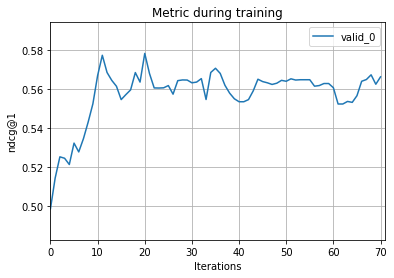

/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future 

Training until validation scores don't improve for 50 rounds
[5]	valid_0's ndcg@1: 0.525247
[10]	valid_0's ndcg@1: 0.568536
[15]	valid_0's ndcg@1: 0.558332
[20]	valid_0's ndcg@1: 0.554913
[25]	valid_0's ndcg@1: 0.555228
[30]	valid_0's ndcg@1: 0.546813
[35]	valid_0's ndcg@1: 0.547496
[40]	valid_0's ndcg@1: 0.553124
[45]	valid_0's ndcg@1: 0.538502
[50]	valid_0's ndcg@1: 0.543657
[55]	valid_0's ndcg@1: 0.539081
[60]	valid_0's ndcg@1: 0.539764
Early stopping, best iteration is:
[12]	valid_0's ndcg@1: 0.569956
0.4762644916025247


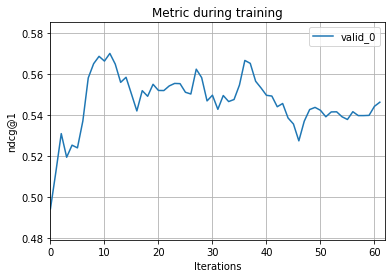

/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future 

Training until validation scores don't improve for 50 rounds
[5]	valid_0's ndcg@1: 0.525934
[10]	valid_0's ndcg@1: 0.532719
[15]	valid_0's ndcg@1: 0.536507
[20]	valid_0's ndcg@1: 0.545644
[25]	valid_0's ndcg@1: 0.538018
[30]	valid_0's ndcg@1: 0.548169
[35]	valid_0's ndcg@1: 0.541331
[40]	valid_0's ndcg@1: 0.533336
[45]	valid_0's ndcg@1: 0.529415
[50]	valid_0's ndcg@1: 0.535306
[55]	valid_0's ndcg@1: 0.529468
[60]	valid_0's ndcg@1: 0.530519
[65]	valid_0's ndcg@1: 0.529941
[70]	valid_0's ndcg@1: 0.540723
[75]	valid_0's ndcg@1: 0.537988
Early stopping, best iteration is:
[29]	valid_0's ndcg@1: 0.560711
0.4644898272559405


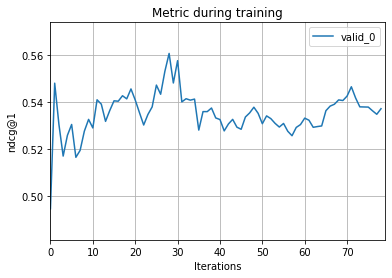

/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future 

Training until validation scores don't improve for 50 rounds
[5]	valid_0's ndcg@1: 0.581159
[10]	valid_0's ndcg@1: 0.602041
[15]	valid_0's ndcg@1: 0.616295
[20]	valid_0's ndcg@1: 0.626131
[25]	valid_0's ndcg@1: 0.618662
[30]	valid_0's ndcg@1: 0.622712
[35]	valid_0's ndcg@1: 0.625237
[40]	valid_0's ndcg@1: 0.615243
[45]	valid_0's ndcg@1: 0.622765
[50]	valid_0's ndcg@1: 0.622975
[55]	valid_0's ndcg@1: 0.616611
[60]	valid_0's ndcg@1: 0.634704
[65]	valid_0's ndcg@1: 0.629024
[70]	valid_0's ndcg@1: 0.630865
[75]	valid_0's ndcg@1: 0.624343
[80]	valid_0's ndcg@1: 0.622817
[85]	valid_0's ndcg@1: 0.607195
[90]	valid_0's ndcg@1: 0.595256
[95]	valid_0's ndcg@1: 0.58947
[100]	valid_0's ndcg@1: 0.599832
[105]	valid_0's ndcg@1: 0.599937
[110]	valid_0's ndcg@1: 0.59757
Early stopping, best iteration is:
[61]	valid_0's ndcg@1: 0.635599
0.46695285989814317


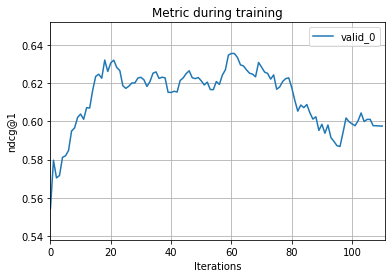

/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future 

Training until validation scores don't improve for 50 rounds
[5]	valid_0's ndcg@1: 0.522339
[10]	valid_0's ndcg@1: 0.535926
[15]	valid_0's ndcg@1: 0.542395
[20]	valid_0's ndcg@1: 0.561331
[25]	valid_0's ndcg@1: 0.55091
[30]	valid_0's ndcg@1: 0.537543
[35]	valid_0's ndcg@1: 0.534253
[40]	valid_0's ndcg@1: 0.542195
[45]	valid_0's ndcg@1: 0.539197
[50]	valid_0's ndcg@1: 0.545456
[55]	valid_0's ndcg@1: 0.55019
[60]	valid_0's ndcg@1: 0.547718
[65]	valid_0's ndcg@1: 0.541249
Early stopping, best iteration is:
[18]	valid_0's ndcg@1: 0.561699
0.4269486057824831


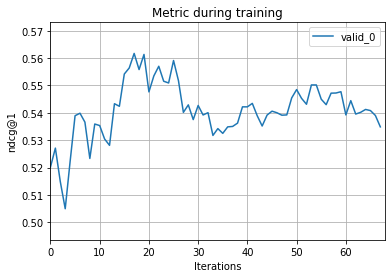

Finish Model training..


In [114]:
train_overfit_sharp_ratio_list = []
sharp_ratio_list = []
importance_list = []

gtscv = GroupTimeSeriesSplit(n_splits=5, max_train_size=None)
for index, (train_id, val_id) in enumerate(gtscv.split(train_x, groups=groups)):
    train_groups = train.iloc[train_id].groupby('Date')['SecuritiesCode'].nunique()
    val_groups = train.iloc[val_id].groupby('Date')['SecuritiesCode'].nunique()

    model_lightgbm, evals_result_lgbm = lgbm_model_rank(train_x.iloc[train_id], train_y.iloc[train_id], train_x.iloc[val_id], train_y.iloc[val_id], train_groups, val_groups)
    # train_overfit = train.iloc[train_id]
    # train_overfit['predict'] = model_lightgbm.predict(train_overfit[col_use])
    # train_overfit = train_overfit.sort_values(["Date", "predict"], ascending=[True, False])
    # ranking = train_overfit.groupby("Date").apply(set_rank).reset_index(drop=True)
    # t_sharp_ratio, _ = calc_spread_return_sharpe(ranking, portfolio_size=200)
    # train_overfit_sharp_ratio_list.append(t_sharp_ratio)
    # print(t_sharp_ratio)

    test['predict'] = model_lightgbm.predict(test[col_use])
    test = test.sort_values(["Date", "predict"], ascending=[True, False])
    ranking = test.groupby("Date").apply(set_rank).reset_index(drop=True)
    sharp_ratio, _ = calc_spread_return_sharpe(ranking, portfolio_size=200)
    sharp_ratio_list.append(sharp_ratio)
    print(sharp_ratio)
    ax = lgb.plot_metric(evals_result_lgbm)
    plt.show()
    importance = pd.DataFrame(model_lightgbm.feature_importance("gain"), index=col_use, columns=['importance'])
    importance_list.append(importance.sort_values(by=['importance'], ascending=False))
print('Finish Model training..')

# 検証用データで精度検証

/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future 

Training until validation scores don't improve for 50 rounds
[5]	valid_0's ndcg@1: 0.562329
[10]	valid_0's ndcg@1: 0.546339
[15]	valid_0's ndcg@1: 0.559541
[20]	valid_0's ndcg@1: 0.539922
[25]	valid_0's ndcg@1: 0.52388
[30]	valid_0's ndcg@1: 0.531296
[35]	valid_0's ndcg@1: 0.526299
[40]	valid_0's ndcg@1: 0.528614
[45]	valid_0's ndcg@1: 0.52267
[50]	valid_0's ndcg@1: 0.521039
[55]	valid_0's ndcg@1: 0.518252
Early stopping, best iteration is:
[6]	valid_0's ndcg@1: 0.565327
0.2399549577877426


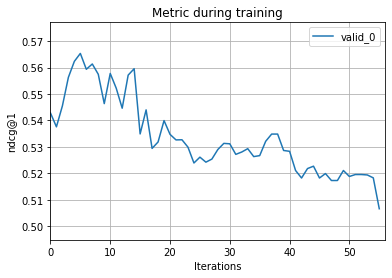

/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future 

Training until validation scores don't improve for 50 rounds
[5]	valid_0's ndcg@1: 0.537766
[10]	valid_0's ndcg@1: 0.551967
[15]	valid_0's ndcg@1: 0.549705
[20]	valid_0's ndcg@1: 0.562908
[25]	valid_0's ndcg@1: 0.557437
[30]	valid_0's ndcg@1: 0.557648
[35]	valid_0's ndcg@1: 0.533505
[40]	valid_0's ndcg@1: 0.528666
[45]	valid_0's ndcg@1: 0.522091
[50]	valid_0's ndcg@1: 0.52388
[55]	valid_0's ndcg@1: 0.524143
[60]	valid_0's ndcg@1: 0.527141
[65]	valid_0's ndcg@1: 0.522933
Early stopping, best iteration is:
[19]	valid_0's ndcg@1: 0.569272
0.38581483156305885


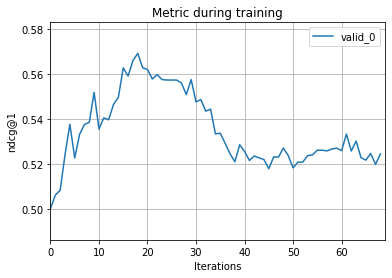

/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future 

Training until validation scores don't improve for 50 rounds
[5]	valid_0's ndcg@1: 0.518069
[10]	valid_0's ndcg@1: 0.544841
[15]	valid_0's ndcg@1: 0.548102
[20]	valid_0's ndcg@1: 0.547891
[25]	valid_0's ndcg@1: 0.547849
[30]	valid_0's ndcg@1: 0.543957
[35]	valid_0's ndcg@1: 0.553498
[40]	valid_0's ndcg@1: 0.55799
[45]	valid_0's ndcg@1: 0.558579
[50]	valid_0's ndcg@1: 0.552373
[55]	valid_0's ndcg@1: 0.554571
[60]	valid_0's ndcg@1: 0.55494
[65]	valid_0's ndcg@1: 0.556475
[70]	valid_0's ndcg@1: 0.556896
[75]	valid_0's ndcg@1: 0.561157
[80]	valid_0's ndcg@1: 0.558947
[85]	valid_0's ndcg@1: 0.554056
[90]	valid_0's ndcg@1: 0.55353
[95]	valid_0's ndcg@1: 0.552688
[100]	valid_0's ndcg@1: 0.553477
[105]	valid_0's ndcg@1: 0.553951
[110]	valid_0's ndcg@1: 0.552793
[115]	valid_0's ndcg@1: 0.558264
[120]	valid_0's ndcg@1: 0.561735
[125]	valid_0's ndcg@1: 0.559631
[130]	valid_0's ndcg@1: 0.562419
[135]	valid_0's ndcg@1: 0.562682
[140]	valid_0's ndcg@1: 0.559736
[145]	valid_0's ndcg@1: 0.558579
[150]

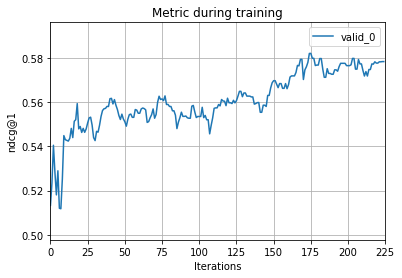

/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future 

Training until validation scores don't improve for 50 rounds
[5]	valid_0's ndcg@1: 0.565169
[10]	valid_0's ndcg@1: 0.570429
[15]	valid_0's ndcg@1: 0.57469
[20]	valid_0's ndcg@1: 0.590364
[25]	valid_0's ndcg@1: 0.594572
[30]	valid_0's ndcg@1: 0.582948
[35]	valid_0's ndcg@1: 0.582579
[40]	valid_0's ndcg@1: 0.578109
[45]	valid_0's ndcg@1: 0.583053
[50]	valid_0's ndcg@1: 0.586314
[55]	valid_0's ndcg@1: 0.580738
[60]	valid_0's ndcg@1: 0.587997
[65]	valid_0's ndcg@1: 0.584841
[70]	valid_0's ndcg@1: 0.583737
Early stopping, best iteration is:
[24]	valid_0's ndcg@1: 0.597833
0.3649791159974583


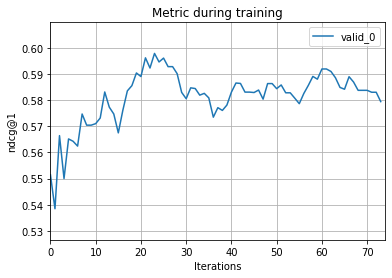

/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/rasuharu/Dev/kaggle/jpx_tokyo_market_prediction/.venv/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future 

Training until validation scores don't improve for 50 rounds
[5]	valid_0's ndcg@1: 0.57421
[10]	valid_0's ndcg@1: 0.562743
[15]	valid_0's ndcg@1: 0.559272
[20]	valid_0's ndcg@1: 0.574262
[25]	valid_0's ndcg@1: 0.57563
[30]	valid_0's ndcg@1: 0.573421
[35]	valid_0's ndcg@1: 0.563743
[40]	valid_0's ndcg@1: 0.566267
[45]	valid_0's ndcg@1: 0.569686
[50]	valid_0's ndcg@1: 0.565478
Early stopping, best iteration is:
[4]	valid_0's ndcg@1: 0.576945
0.2873168695545029


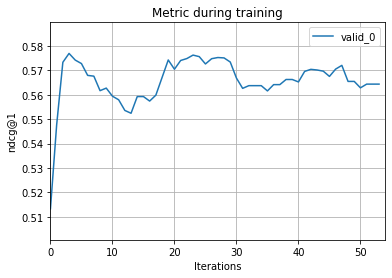

Finish Model training..


In [144]:
train_overfit_sharp_ratio_list = []
sharp_ratio_list = []
importance_list = []

gtscv = GroupTimeSeriesSplit(n_splits=5, max_train_size=None)
for index, (train_id, val_id) in enumerate(gtscv.split(train_x, groups=groups)):
    train_groups = train.iloc[train_id].groupby('Date')['SecuritiesCode'].nunique()
    val_groups = train.iloc[val_id].groupby('Date')['SecuritiesCode'].nunique()

    model_lightgbm, evals_result_lgbm = lgbm_model_rank(train_x.iloc[train_id], train_y.iloc[train_id], train_x.iloc[val_id], train_y.iloc[val_id], train_groups, val_groups)
    # train_overfit = train.iloc[train_id]
    # train_overfit['predict'] = model_lightgbm.predict(train_overfit[col_use])
    # train_overfit = train_overfit.sort_values(["Date", "predict"], ascending=[True, False])
    # ranking = train_overfit.groupby("Date").apply(set_rank).reset_index(drop=True)
    # t_sharp_ratio, _ = calc_spread_return_sharpe(ranking, portfolio_size=200)
    # train_overfit_sharp_ratio_list.append(t_sharp_ratio)
    # print(t_sharp_ratio)

    val['predict'] = model_lightgbm.predict(val[col_use])
    val = val.sort_values(["Date", "predict"], ascending=[True, False])
    ranking = val.groupby("Date").apply(set_rank).reset_index(drop=True)
    sharp_ratio, _ = calc_spread_return_sharpe(ranking, portfolio_size=200)
    sharp_ratio_list.append(sharp_ratio)
    print(sharp_ratio)
    ax = lgb.plot_metric(evals_result_lgbm)
    plt.show()
    importance = pd.DataFrame(model_lightgbm.feature_importance("gain"), index=col_use, columns=['importance'])
    importance_list.append(importance.sort_values(by=['importance'], ascending=False))
print('Finish Model training..')

In [145]:
sharp_ratio_list

[0.2399549577877426,
 0.38581483156305885,
 0.3004641749277935,
 0.3649791159974583,
 0.2873168695545029]

In [146]:
np.mean(sharp_ratio_list)

0.3157059899661112

In [150]:
importance_list[4]

,importance
ScaledAdjustedClose,736.772586
sma_25_30,95.104356
ror_5,62.380521
ror_1,33.242252
sma_5_25,19.602056
trend_aroon_ind_diff1,9.150898


In [380]:
importance = pd.DataFrame(model_lightgbm.feature_importance("gain"), index=col_use, columns=['importance'])
importance.sort_values(by=['importance'], ascending=False)

,importance
ScaledAdjustedClose,1806.836062
sma_25_30,302.456329
day_range_1,203.891412
ror1_ror3,154.384700
ror_1_shift1,91.962759
ror1_ror5,67.998840
d_atr,57.499599
gap_range_1,56.005474
Volume,55.491063
day,47.135790


In [359]:
importance = pd.DataFrame(model_lightgbm.feature_importance("gain"), index=col_use, columns=['importance'])
importance.sort_values(by=['importance'], ascending=False)

,importance
close_arccos_deg,855.117970
sma_25_30,176.490097
day_range_1,161.243944
ScaledAdjustedLow,132.212241
ScaledAdjustedOpen,111.412399
ror1_ror3,109.323999
ror1_ror5,70.563380
ScaledAdjustedHigh,69.631960
ScaledAdjustedClose,51.102729
ror_1_shift1,48.124580


In [277]:
_

Date
2022-01-04    1.857898
2022-01-05    1.801836
2022-01-06    3.197155
2022-01-07    0.227664
2022-01-11   -0.736227
2022-01-12   -0.002046
2022-01-13    0.645428
2022-01-14    0.728061
2022-01-17    1.821896
2022-01-18    1.081732
2022-01-19    2.883402
2022-01-20    1.018611
2022-01-21    3.620093
2022-01-24    0.160646
2022-01-25    4.292358
2022-01-26   -0.231962
2022-01-27   -3.897746
2022-01-28    0.889400
2022-01-31   -0.067844
2022-02-01    2.616927
2022-02-02   -1.087795
2022-02-03    1.921754
2022-02-04    0.945762
2022-02-07   -0.945777
2022-02-08    0.421216
2022-02-09    0.135154
2022-02-10    1.737313
2022-02-14   -0.336485
2022-02-15   -0.008300
2022-02-16    0.045816
2022-02-17    1.060351
2022-02-18    0.695764
2022-02-21    1.053731
2022-02-22   -1.797509
2022-02-24    0.013550
2022-02-25   -1.638137
2022-02-28   -2.617426
dtype: float64

In [ ]:
# gtscv = GroupTimeSeriesSplit(n_splits=5, max_train_size=None)
# for index, (train_id, val_id) in enumerate(gtscv.split(train_x, groups=groups)):
#     model = random_forest_model(train_x.iloc[train_id], train_y.iloc[train_id], train_x.iloc[val_id], train_y.iloc[val_id], index)
#     test['predict'] = model.predict(test[col_use])
#     test = test.sort_values(["Date", "predict"], ascending=[True, False])
#     ranking = test.groupby("Date").apply(set_rank).reset_index(drop=True)
#     sharp_ratio, _ = calc_spread_return_sharpe(ranking, portfolio_size=200)

#     print(sharp_ratio)
#     print('Output of LightGBM Model training..')